# Question 2

This dataset provides monthly operational metrics for a major Indian airline
from 2013. It includes information on the number of departures, flight hours,
distance flown, passenger traffic, available seat kilometers, freight carried,
and mail carried. You can use any popular time series library for this task.

In [1410]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from wheel.util import native

data = pd.read_csv('AirtrafficA4.csv')

Removing `null` values out of the data, adding a new `timestamp` column showing month + year in a specific formate.

In [1411]:
data['MONTH'] = data['MONTH'].str.strip().replace({ 'JUNE': 'JUN', 'JULY': 'JUL' }).astype(str)
data['YEAR'] = data['YEAR'].astype(str)
data['TIMESTAMP'] = pd.to_datetime(data['YEAR'] + '-' + data['MONTH'] + '-01', format='%Y-%b-%d')
data.fillna(0, inplace=True)

Making `TIMESTAMP` as the index and sorting according to it, so I can plot easily

In [1412]:
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'])
data.set_index('TIMESTAMP', inplace=True)
data = data.asfreq('MS')
data.sort_index(inplace=True)

data['PASSENGERS CARRIED'] = data['PASSENGERS CARRIED'].astype(str).str.replace(',', '').astype(float)
data.to_csv('Temp.csv')

Plotting a graph of passengers carried by the plan each month

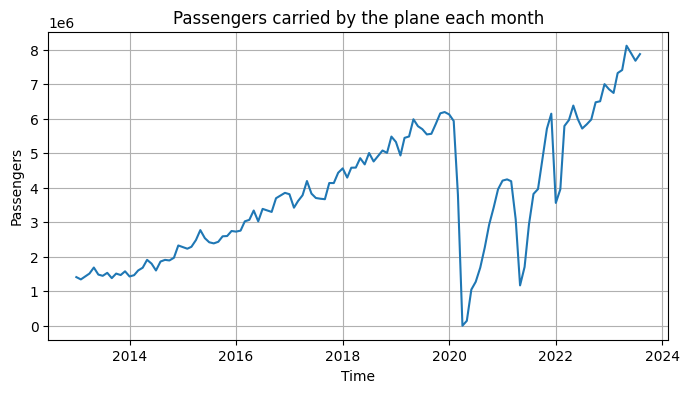

In [1413]:
plt.figure(figsize=(8, 4))
plt.plot(data.index, data['PASSENGERS CARRIED'])
plt.title('Passengers carried by the plane each month')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

To remove the trend, we can use differencing. Let's plot the differenced data

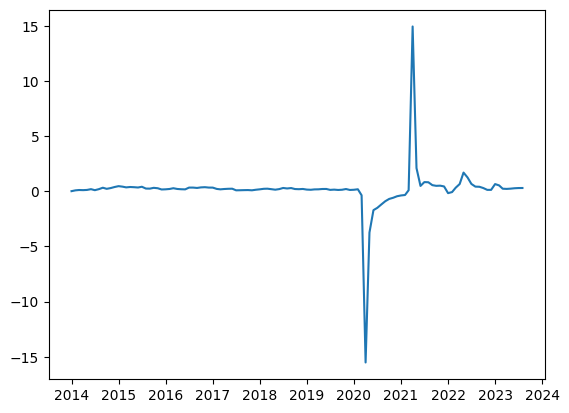

In [1414]:
data['LOG_PASSENGERS'] = np.log(data['PASSENGERS CARRIED'].apply(lambda x: x+1 if x == 0 else -x if x < 0 else x))
data['DIFF_PASSENGERS'] = data['LOG_PASSENGERS'].diff(periods=12)
data.dropna(inplace=True)
plt.plot(data.index, data['DIFF_PASSENGERS'])
plt.show()


Since the data is sorted according to `TIMESTAMP`, let's just split it into training and testing data


In [1415]:
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

train.to_csv('Train.csv')
test.to_csv('Test.csv')

Let's plot ACF, PACF for AR(p) and MA(q) models.

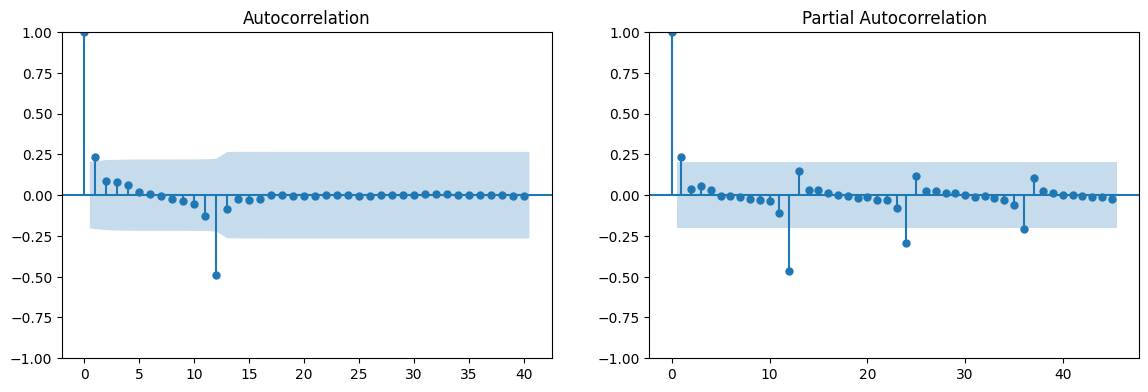

In [1416]:
plt.figure(figsize=(120, 50))
plt.subplot(10, 16, 1)
plot_acf(train['DIFF_PASSENGERS'].dropna(), lags=40, ax=plt.gca())
plt.subplot(10, 16, 2)
plot_pacf(train['DIFF_PASSENGERS'].dropna(), lags=45, ax=plt.gca())
plt.show()

Since there is seasonality here, let's try an AutoARIMA model

In [1417]:
model = SARIMAX(train['DIFF_PASSENGERS'], order=(2, 0, 2), seasonal_order=(0, 1, 1, 12), freq='MS')
sarima_fit = model.fit(disp=False)

predictions = sarima_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / np.abs(y_train.iloc[n - 1] - y_train.iloc[0])

mase_value = mase(test['DIFF_PASSENGERS'], predictions, train['DIFF_PASSENGERS'])
mape_value = np.mean(np.abs((test['DIFF_PASSENGERS'] - predictions) / test['DIFF_PASSENGERS'])) * 100

print(f'Mean Absolute Percentage Error: {mape_value}')
print(f'Mean Absolute Scaled Error: {mase_value}')

/home/awez_mehtab/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Mean Absolute Percentage Error: 81.34704513004039
Mean Absolute Scaled Error: 0.4318347716290733


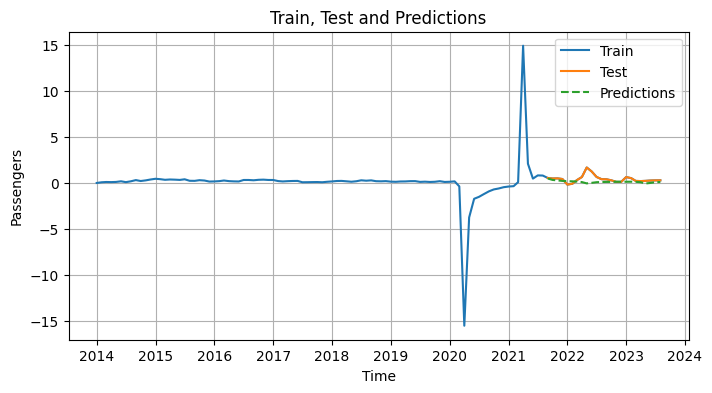

In [1418]:
plt.figure(figsize=(8, 4))
plt.plot(data.index, data['DIFF_PASSENGERS'], label='Train')
plt.plot(test.index, test['DIFF_PASSENGERS'], label='Test')
plt.plot(test.index, predictions, label='Predictions', linestyle='--')
plt.title('Train, Test and Predictions')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.legend()
plt.grid(True)
plt.show()

Using it to predict the `PASSENGERS CARRIED` from 2023 SEP to 2024 AUG

In [1419]:
data_range = pd.date_range(start='2023-09-01', end='2024-08-01', freq='MS')
future_data = pd.DataFrame(index=data_range, columns=['PASSENGERS CARRIED'])

future_diff_pred = sarima_fit.predict(start=len(data), end=len(data)+len(data_range)-1, dynamic=False)
print(future_diff_pred)

last_log_value = data['LOG_PASSENGERS'].iloc[-12]
future_pred = []
for i in range(len(future_diff_pred)):
    last_log = data['LOG_PASSENGERS'].iloc[-12 + i]
    future_pred.append(np.exp(future_diff_pred.iloc[i] + last_log) - 1)
    
future_pred = [int(i) for i in future_pred]

future_data['PASSENGERS CARRIED'] = future_pred
future_data['YEAR_MONTH'] = future_data.index.strftime('%Y %b').str.upper()

future_data.reset_index(drop=True, inplace=True)
future_data = future_data[['YEAR_MONTH', 'PASSENGERS CARRIED']]
future_data.to_csv('Future.csv')
future_data

2023-09-01    0.124036
2023-10-01    0.124514
2023-11-01    0.140785
2023-12-01    0.140895
2024-01-01    0.144519
2024-02-01    0.148874
2024-03-01    0.138046
2024-04-01    0.091218
2024-05-01   -0.044473
2024-06-01    0.018102
2024-07-01    0.088732
2024-08-01    0.114042
Freq: MS, Name: predicted_mean, dtype: float64


,YEAR_MONTH,PASSENGERS CARRIED
0,2023 SEP,6761150
1,2023 OCT,7329537
2,2023 NOV,7483690
3,2023 DEC,8056212
4,2024 JAN,7912039
5,2024 FEB,7824209
6,2024 MAR,8400456
7,2024 APR,8113809
8,2024 MAY,7756870
9,2024 JUN,8037479
